In [4]:
import pandas as pd 
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.pyplot import figure

os.chdir('C:\\Users\\mohda\\Documents\\kffnf_jugnu_private')


In [5]:
#Extract the income and expenditure data saved in 'jugnu_hies.ipynb'
exp=pd.read_csv("data/data_hies/tot_exp.csv")
inc=pd.read_csv("data/data_hies/inc_data.csv")

#Extract the district coding
coding=pd.read_csv("data/data_hies/dist_coding.csv")
coding=coding[['stratum','code']]
coding=coding.drop_duplicates()

#Extract the survey weights
wgt=pd.read_spss("data/data_hies/data_in_stata/weight.sav")

#Rename KPK
exp.loc[exp['Province']=='KP','Province']='Khyber Pakhtunkhwa'

#Keep only the important columns
exp=exp[['hhcode','Province','Region','PSU','itc','v1']]

#Combine those
inc_exp=pd.merge(exp,inc,how='inner',left_on=['hhcode','Province','Region'],right_on=['hhcode','Province','Region'])

#Merge the weights
inc=pd.merge(inc,wgt,how='inner',left_on='PSU',right_on='psu')
exp=pd.merge(exp,wgt,how='inner',left_on='PSU',right_on='psu')

#Convert data types
inc['PSU_str']=inc['PSU'].astype(str)
exp['PSU_str']=exp['PSU'].astype(str)
inc['district'] = inc['PSU_str'].str[:4]
inc['district']=inc['district'].astype('int64')
exp['district'] = exp['PSU_str'].str[:4]
exp['district']=exp['district'].astype('int64')
inc=inc.drop('PSU_str',axis=1)
exp=exp.drop('PSU_str',axis=1)

#Rename the categories of expenditure
itc_dictionary={'Pant/Shirts/ Shalwar Kameez Suit/ suit(pant coat) Boys/Gents (New/Second Hand)':'men_clothing',
               'Clothes for women/ girls  Frocks /T-Shirts/Shalwar Suites/Tights /Saree’s etc/ Dopatta/ chaddar':'women_clothing',
                'Bread , Paratha,Nan,Roti etc.':'bread_basic','House Rent':'rent','Bread, Bun, Sheermal':'bread_other', 
                'Household Servant (full time)':'servant_fulltime','House and property tax':'house_tax', 'Household Servant (part time)':'servant_parttime',
                'Private School/ College/ University/ Medical College/ Engineering College /University Fee':'private_school',
                'Govt. School/ College/ University/ Medical College/ Engineering College /University Fee':'govt_school',
                'Medicines/ Tablets/ Syrups etc.':'medical',
                'Doctor Fee (Hakeem/ homeopathic/specialist/general etc.)':'medical',
                'LPG (Liquid Petroleum Gas)':'fuel',
                'Petrol/ Diesel/  Mobil oil  Expenses':'fuel',
                'CNG Expenses':'fuel',
                'Private vehicle (Bus, Wagon, Taxi etc.)  fare (Outside City)':'transport',
                'Private vehicle (Rickshaw, Bus , Suzuki, Taxi etc.)  fare (with in City)':'transport',
                'Telephone, Mobile Charges (Easy load, Mobile card, repairing etc.)':'telecom',
                'Internet Charges (DSL/Broadband/EVO etc.)/ Fax Charges':'internet'
                
               }


exp['itc'] = exp.apply(lambda x: itc_dictionary.get(x['itc'], 'Unknown'), axis=1)
from scipy import stats

#Normalize expenditures
exp=exp[np.abs(exp.v1-exp.v1.mean()) <= (3*exp.v1.std())]

#get district codes
inc=pd.merge(inc,coding,how='left',left_on='district',right_on='code')
exp=pd.merge(exp,coding,how='left',left_on='district',right_on='code')

#Save district wise observation count
dist_counts=pd.DataFrame(inc.groupby(['stratum']).size(),columns=['count'])
dist_counts.to_csv("data/data_hies/dist_counts.csv")
inc.to_csv("data/data_hies/income_complete.csv")
exp.to_csv("data/data_hies/expenditure_complete.csv")

#rename the straturms
exp_lahore=exp[exp['stratum']=="LAHORE"]
exp_isb=exp[exp['stratum']=="ISLAMABAD"]
exp_khi=exp[exp['stratum']=="KARACHI"]

exp_lahore.to_csv("data/processed/exp_lahore.csv")
exp_isb.to_csv("data/processed/exp_isb.csv")
exp_khi.to_csv("data/processed/exp_khi.csv")



inc_lahore=inc[inc['stratum']=="LAHORE"]
inc_isb=inc[inc['stratum']=="ISLAMABAD"]
inc_khi=inc[inc['stratum']=="KARACHI"]
inc_lahore.to_csv("data/processed/inc_lahore.csv")
inc_lahore.to_csv("data/processed/inc_karachi.csv")
inc_lahore.to_csv("data/processed/inc_islamabad.csv")


rent_lhr=exp_lahore[exp_lahore['itc']=='rent']
rent_isb=exp_isb[exp_isb['itc']=='rent']
rent_khi=exp_khi[exp_khi['itc']=='rent']

In [6]:
exp.groupby('itc').size()

itc
Unknown             37520
bread_basic          6164
bread_other          6166
fuel                17058
govt_school          7429
house_tax              83
internet             2382
medical             44816
men_clothing        16196
private_school       5876
rent                 1515
servant_fulltime      147
servant_parttime      549
telecom             22809
transport           39462
women_clothing      17493
dtype: int64

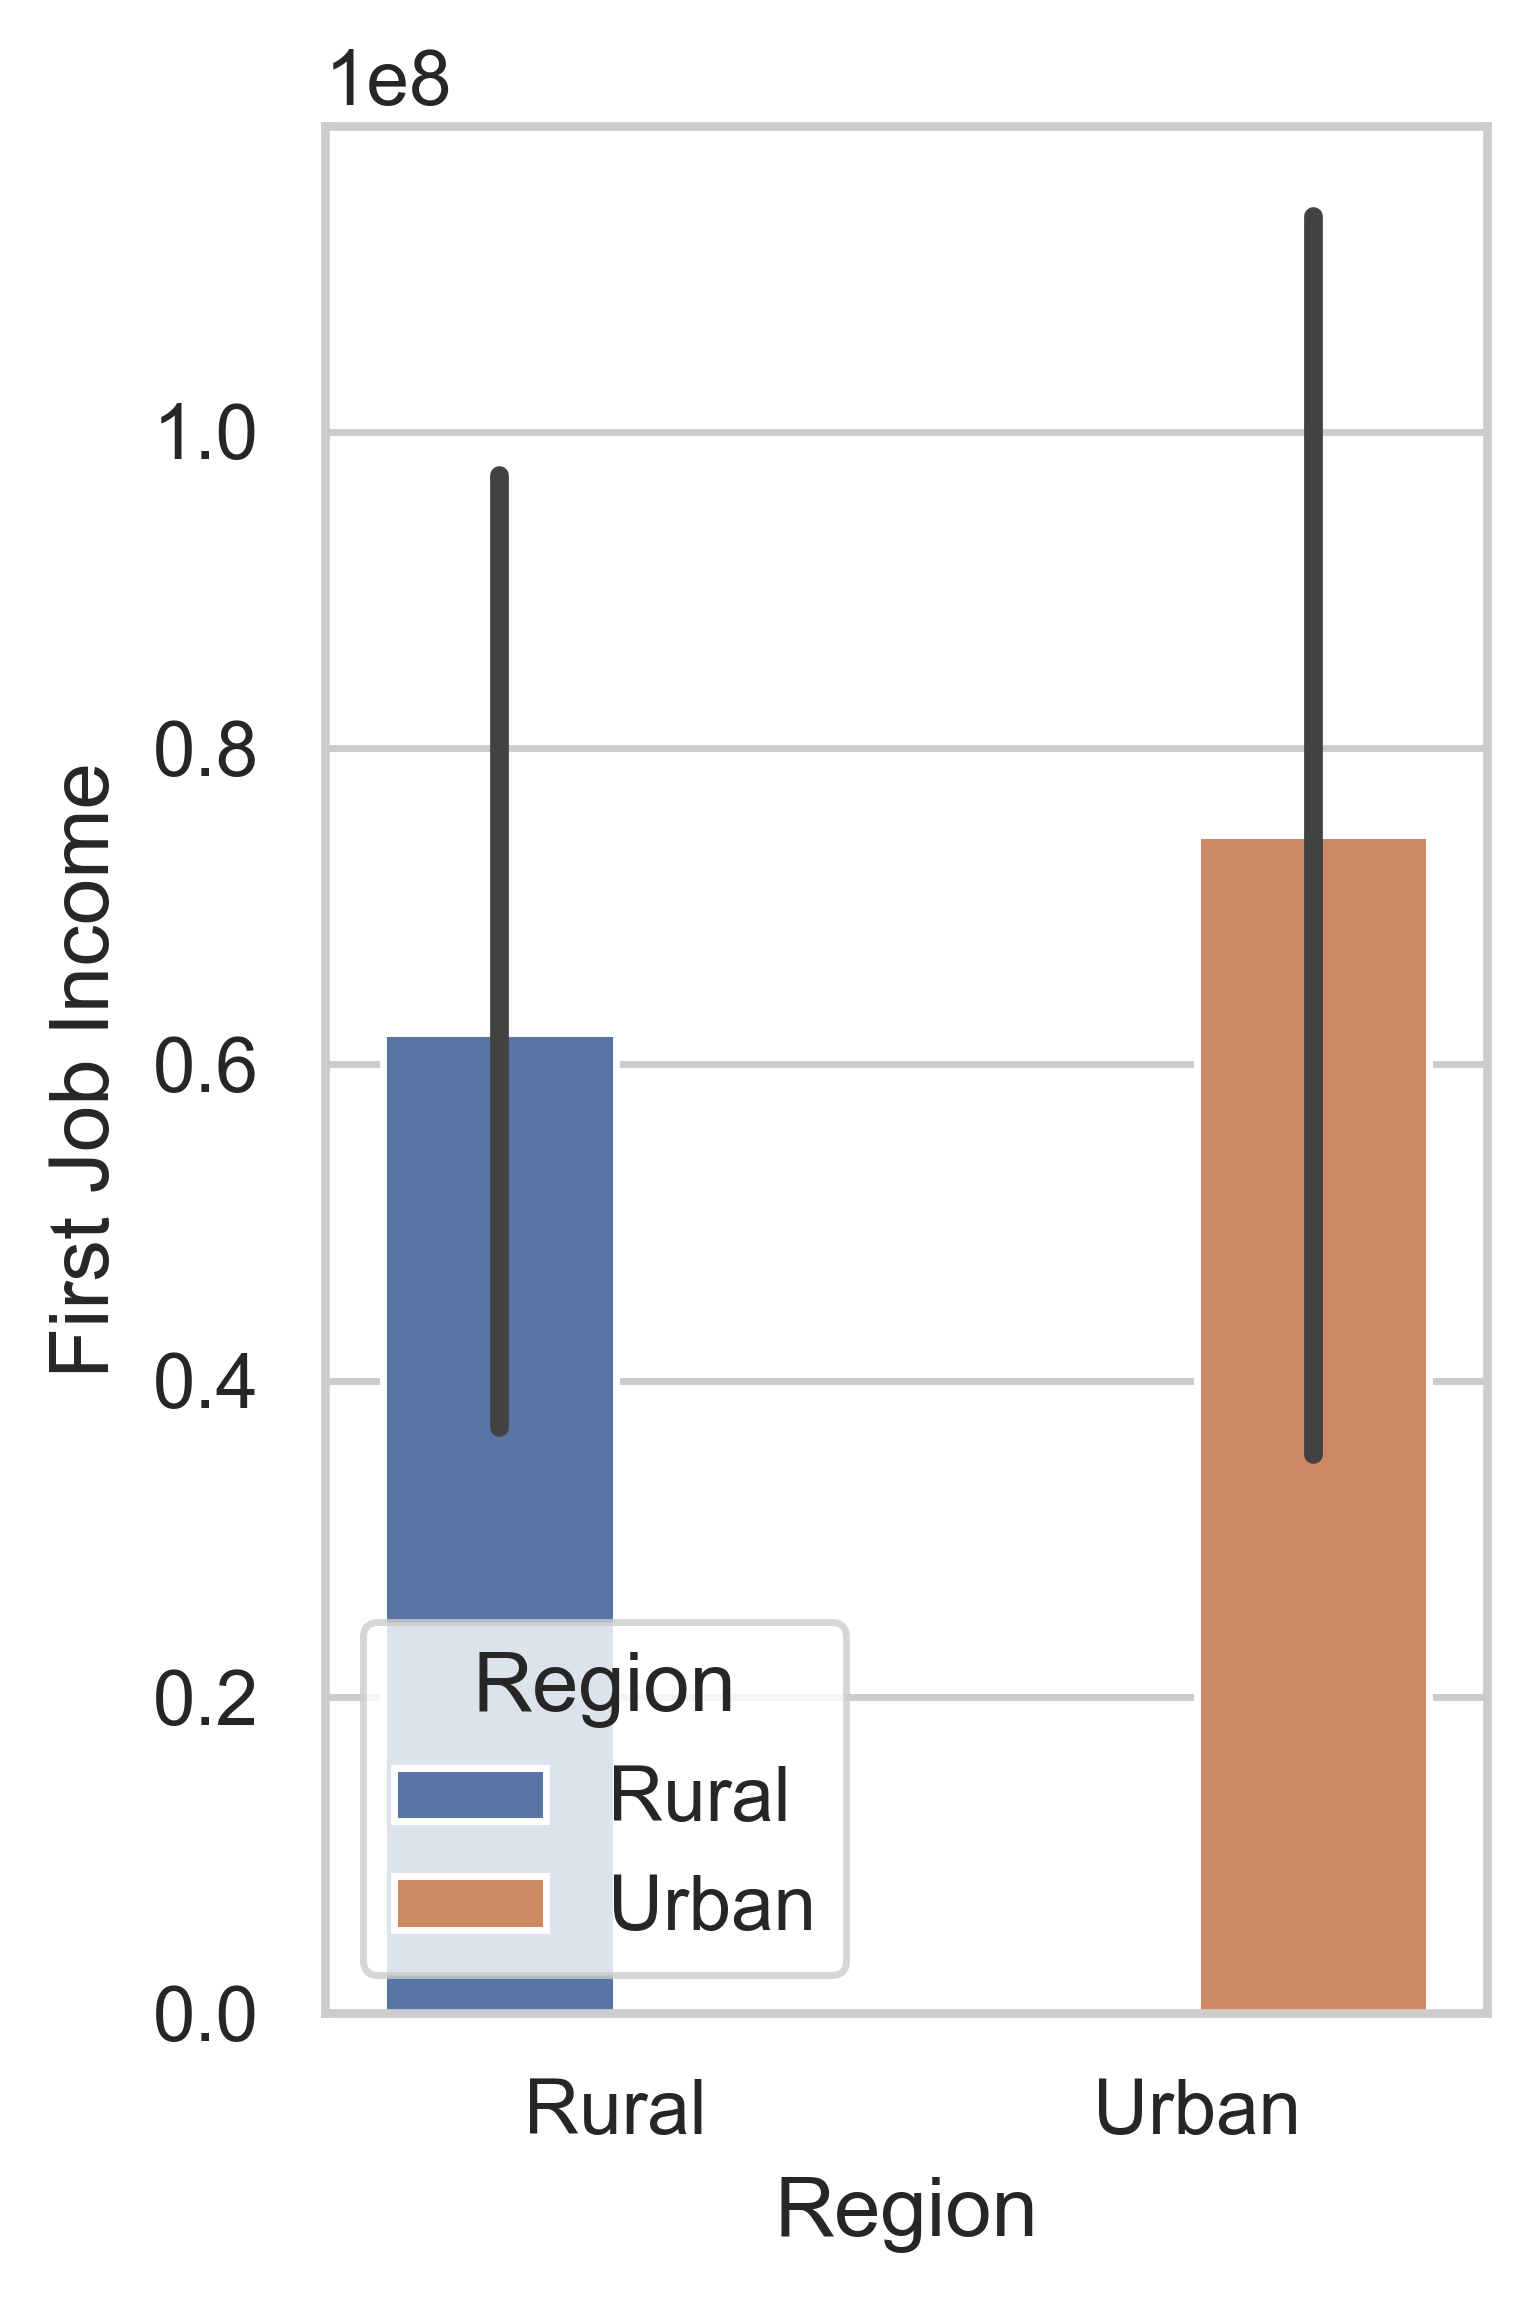

In [7]:
inc_hh=inc.groupby(['hhcode'],as_index=False).agg({'first_job_income': 'sum', 'second_job_income': 'sum'})
sum_inc=inc.groupby(['Region','Province'],as_index=False).agg({'first_job_income': 'sum', 'second_job_income': 'sum'})
sns.set_theme(style="whitegrid")


figure(figsize=(3, 5), dpi=500)
ax = sns.barplot(x="Region", y="first_job_income",hue="Region", data=sum_inc)
ax.set(xlabel='Region', ylabel='First Job Income')
plt.savefig('viz/hies/inc_province.png')

In [8]:
import matplotlib.style as style 
style.use('ggplot')
exp_sum=exp.groupby(['Region','Province','itc'],as_index=False).agg({'v1': 'mean'})

style.use('ggplot')

In [9]:
sns.color_palette("Paired")
figure(figsize=(25, 20), dpi=500)
ax = sns.barplot(x="Province", y="v1",hue="itc", data=exp_sum,palette=("Spectral"))

ax.set(xlabel='Province', ylabel='Expenditure')
plt.savefig('viz/hies/exp_province.png')

In [10]:
exp.loc[exp['itc']=='house_tax','v1'].sort_values(ascending=False)
exp.loc[exp['v1']==171600]

,hhcode,Province,Region,PSU,itc,v1,psu,weight,district,stratum,code


In [11]:
exp.head()

,hhcode,Province,Region,PSU,itc,v1,psu,weight,district,stratum,code
0,1.102100e+09,Khyber Pakhtunkhwa,Urban,11021001.0,men_clothing,6000.0,11021001.0,542.337805,1102,MALAKAND,1102.0
1,1.102100e+09,Khyber Pakhtunkhwa,Urban,11021001.0,Unknown,2000.0,11021001.0,542.337805,1102,MALAKAND,1102.0
2,1.102100e+09,Khyber Pakhtunkhwa,Urban,11021001.0,women_clothing,1000.0,11021001.0,542.337805,1102,MALAKAND,1102.0
3,1.102100e+09,Khyber Pakhtunkhwa,Urban,11021001.0,Unknown,1200.0,11021001.0,542.337805,1102,MALAKAND,1102.0
4,1.102100e+09,Khyber Pakhtunkhwa,Urban,11021001.0,fuel,450.0,11021001.0,542.337805,1102,MALAKAND,1102.0


[Text(0.5, 0, 'Region'), Text(0, 0.5, 'Expenditure')]

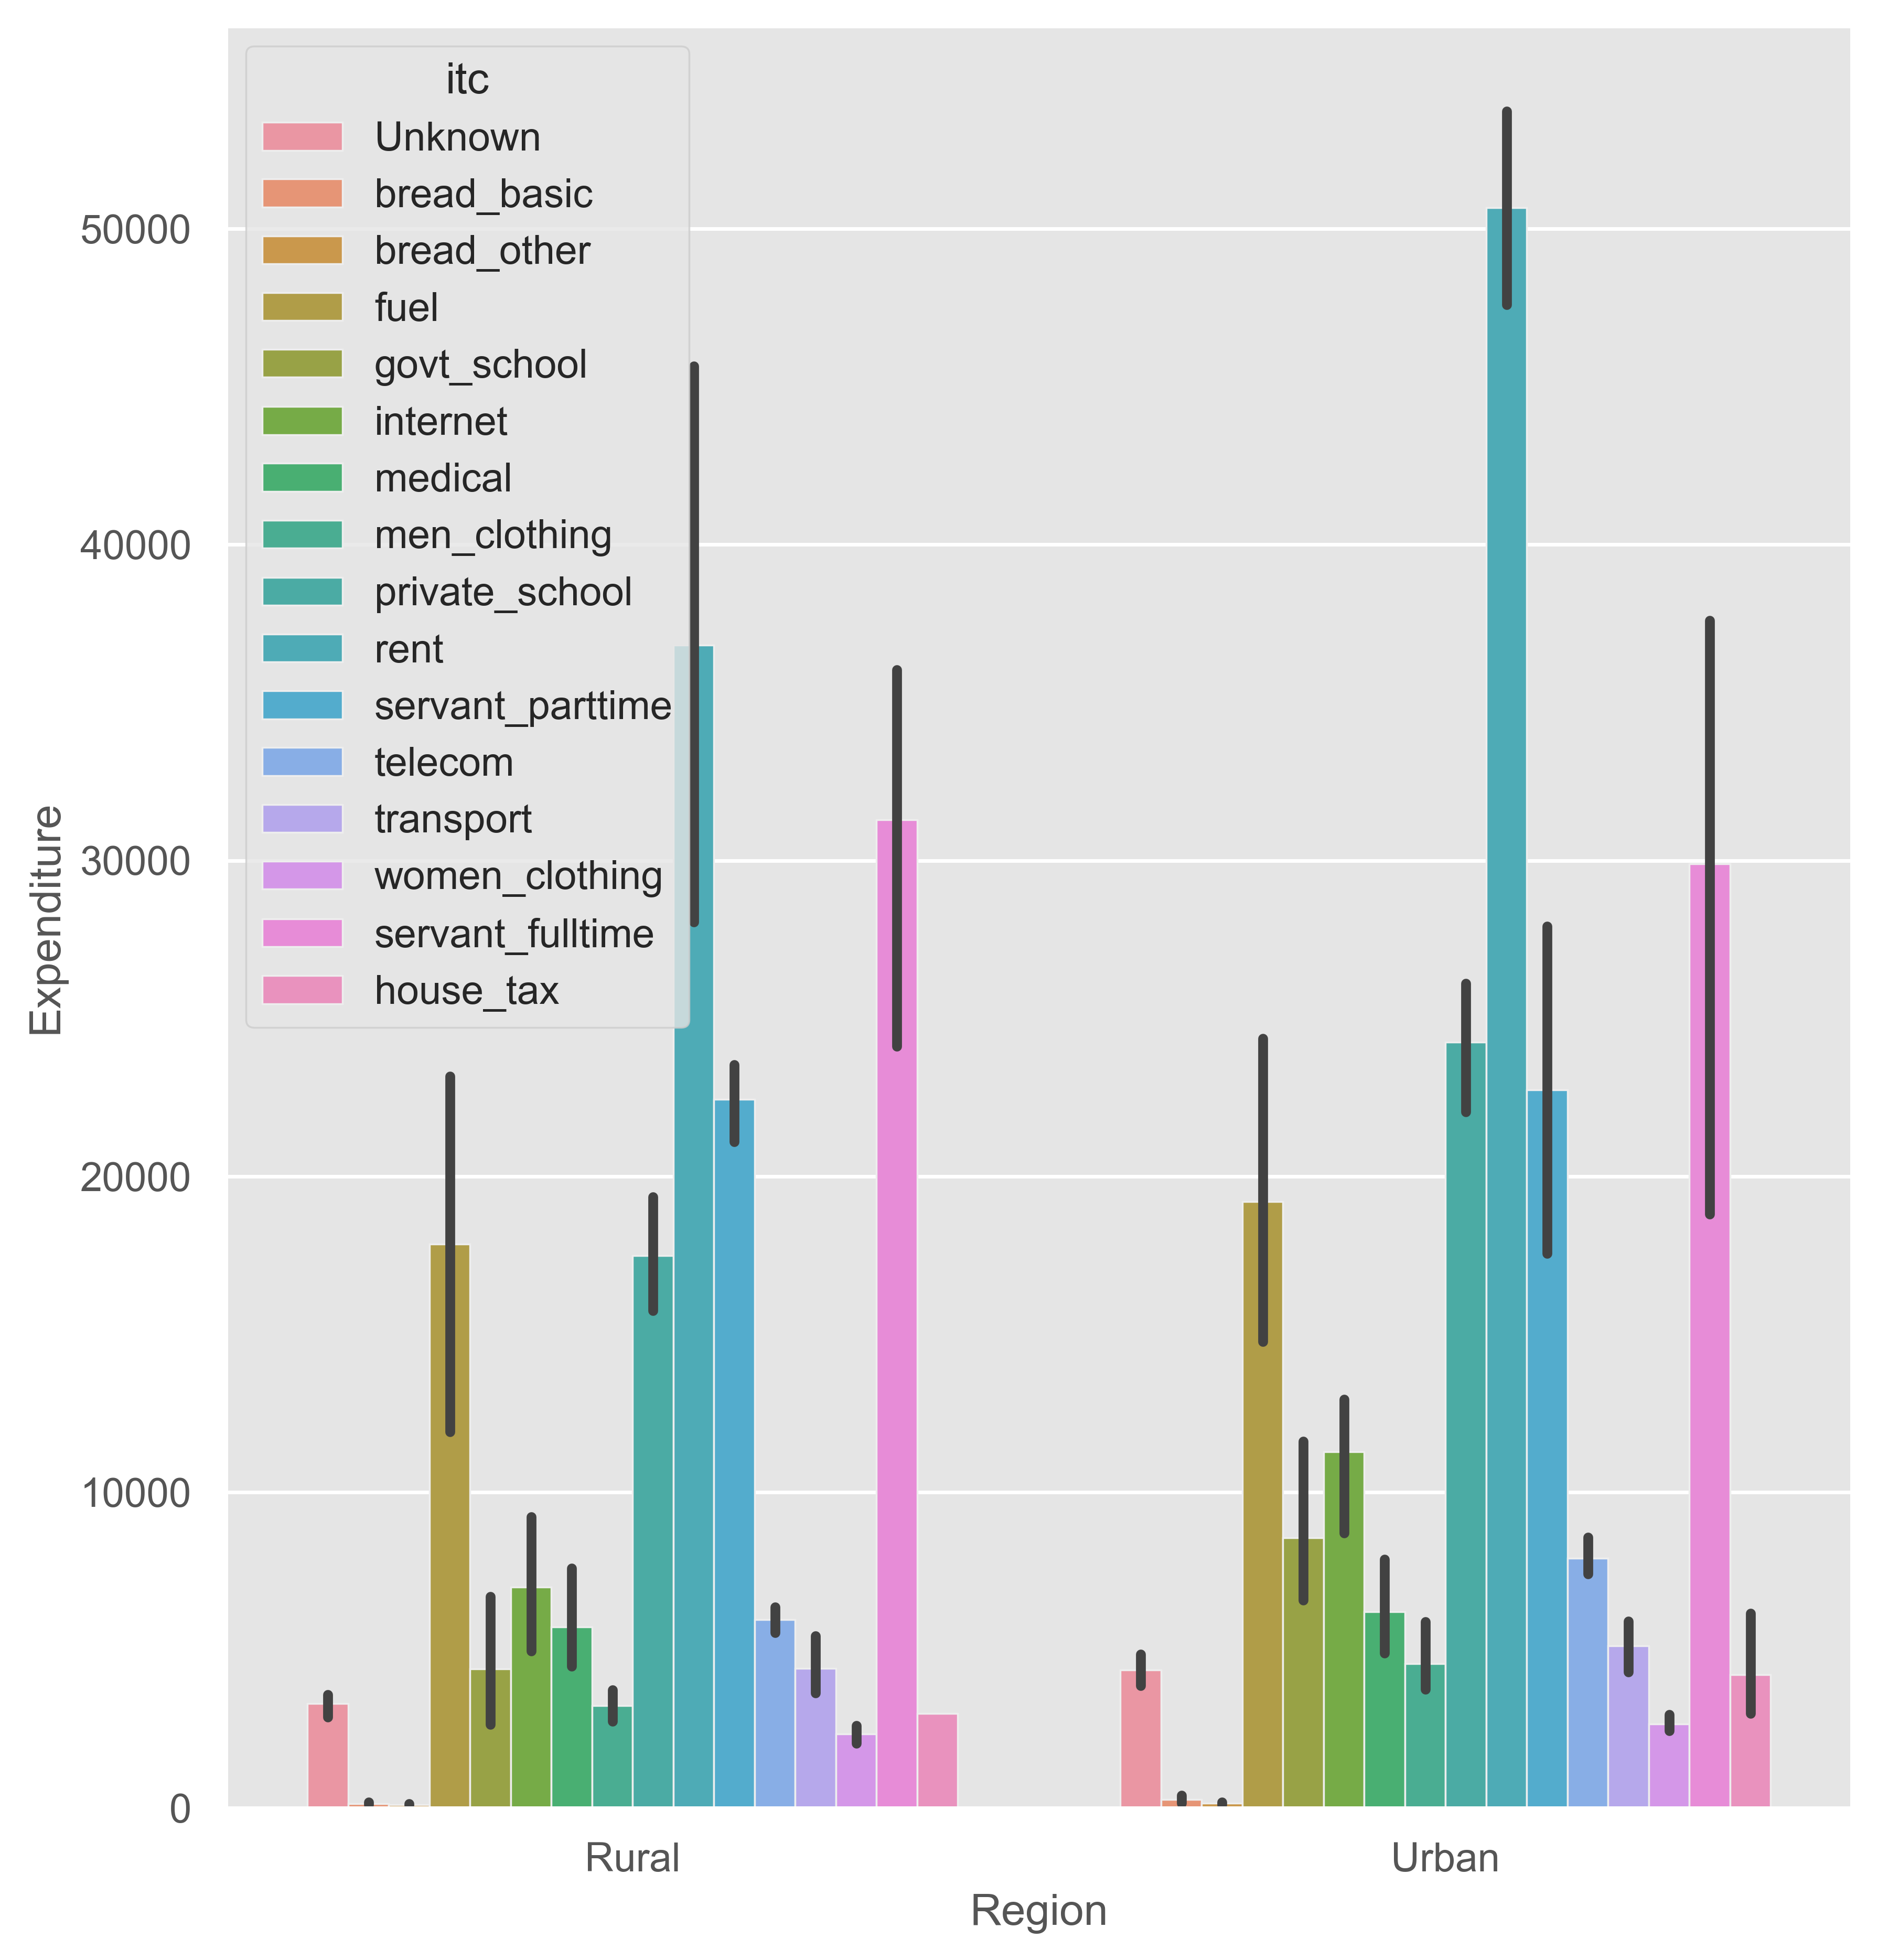

In [12]:
exp_sum=exp.groupby(['Region','Province','itc'],as_index=False).agg({'v1': 'mean'})
figure(figsize=(8, 9), dpi=500)
ax = sns.barplot(x="Region", y="v1",hue="itc", data=exp_sum)

ax.set(xlabel='Region', ylabel='Expenditure')

In [13]:
exp_sum.head()

,Region,Province,itc,v1
0,Rural,Balochistan,Unknown,3360.589113
1,Rural,Balochistan,bread_basic,219.217687
2,Rural,Balochistan,bread_other,72.913669
3,Rural,Balochistan,fuel,18485.390963
4,Rural,Balochistan,govt_school,4333.947368


In [11]:
inc_lahore.shape

(1986, 13)

In [12]:
len(rent_lhr['hhcode'].unique())

190

,Unnamed: 0,hhcode,Province,Region,PSU,idc,first_job_income,second_job_income,psu,weight
0,5,1102100102.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,2.000000,20000.000000,NaN,11021001.000000,542.337805
1,11,1102100103.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,1.000000,100000.000000,NaN,11021001.000000,542.337805
2,12,1102100103.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,2.000000,40000.000000,NaN,11021001.000000,542.337805
3,17,1102100104.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,1.000000,10000.000000,NaN,11021001.000000,542.337805
4,29,1102100106.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,3.000000,10000.000000,NaN,11021001.000000,542.337805


In [153]:

exp.head()

,hhcode,Province,Region,PSU,itc,v1,psu,weight,district_x,stratum_x,code,s.no,stratum_y,district_y
0,1102100101.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,men_clothing,6000.000000,11021001.000000,542.337805,1102,MALAKAND,1102.000000,1,MALAKAND,CHITRAL DISTRICT
1,1102100101.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,men_clothing,6000.000000,11021001.000000,542.337805,1102,MALAKAND,1102.000000,2,MALAKAND,UPPER DIR DISTRICT
2,1102100101.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,men_clothing,6000.000000,11021001.000000,542.337805,1102,MALAKAND,1102.000000,3,MALAKAND,LOWER DIR DISTRICT
3,1102100101.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,men_clothing,6000.000000,11021001.000000,542.337805,1102,MALAKAND,1102.000000,4,MALAKAND,SWAT DISTRICT
4,1102100101.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,men_clothing,6000.000000,11021001.000000,542.337805,1102,MALAKAND,1102.000000,5,MALAKAND,SHANGLA DISTRICT


,hhcode,Province,Region,PSU,itc,v1,psu,weight,district,stratum,code
0,1102100101.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,Pant/Shirts/ Shalwar Kameez Suit/ suit(pant co...,6000.000000,11021001.000000,542.337805,1102,MALAKAND,1102.000000
1,1102100101.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,Clothes for women/ girls Frocks /T-Shirts/Sha...,1000.000000,11021001.000000,542.337805,1102,MALAKAND,1102.000000
2,1102100101.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,"Bread , Paratha,Nan,Roti etc.",100.000000,11021001.000000,542.337805,1102,MALAKAND,1102.000000
3,1102100102.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,Pant/Shirts/ Shalwar Kameez Suit/ suit(pant co...,1600.000000,11021001.000000,542.337805,1102,MALAKAND,1102.000000
4,1102100102.000000,Khyber Pakhtunkhwa,Urban,11021001.000000,Clothes for women/ girls Frocks /T-Shirts/Sha...,1650.000000,11021001.000000,542.337805,1102,MALAKAND,1102.000000


In [23]:

inc.head()

,Unnamed: 0,hhcode,Province,Region,PSU,idc,first_job_income,second_job_income,psu,weight,district,stratum,code
0,5,1.102100e+09,Khyber Pakhtunkhwa,Urban,11021001.0,2.0,20000.0,NaN,11021001.0,542.337805,1102,MALAKAND,1102.0
1,11,1.102100e+09,Khyber Pakhtunkhwa,Urban,11021001.0,1.0,100000.0,NaN,11021001.0,542.337805,1102,MALAKAND,1102.0
2,12,1.102100e+09,Khyber Pakhtunkhwa,Urban,11021001.0,2.0,40000.0,NaN,11021001.0,542.337805,1102,MALAKAND,1102.0
3,17,1.102100e+09,Khyber Pakhtunkhwa,Urban,11021001.0,1.0,10000.0,NaN,11021001.0,542.337805,1102,MALAKAND,1102.0
4,29,1.102100e+09,Khyber Pakhtunkhwa,Urban,11021001.0,3.0,10000.0,NaN,11021001.0,542.337805,1102,MALAKAND,1102.0
